<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chapter11_capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/AusAntidiabeticDrug.csv")
df

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


## 훈련 / 테스트 집합 분할

이 프로젝트의 목표는 1991년부터 2008년 까지 호주의 항당뇨제 처방 건수를 예측하는 것이다. 롤링 예측을 수행할 수 있도록 데이터 집합에서 지난 36개월을 테스트 집합으로 사용하자.

In [67]:
y = df['y']
train = y[:-36]
train

,y
0,3.526591
1,3.180891
2,3.252221
3,3.611003
4,3.565869
...,...
163,12.154552
164,13.402392
165,14.459239
166,14.795102


# 베이스라인 모델 설정
베이스라인 모델은 단순한 계절 예측으로, 예측하려는 년도의 직전 년도 각 월의 처방 건수를 에측으로 사용한다.

In [28]:
len(y.iloc[1:2])

1

In [42]:
test = pd.DataFrame(y.iloc[-36:])
test['naive_seasonal'] = y.iloc[156:-12].values
test.head()

,y,naive_seasonal
168,15.829550,15.339097
169,17.554701,15.370764
170,18.100864,16.142005
171,17.496668,16.685754
172,19.347265,17.636728


# 정상성 확인

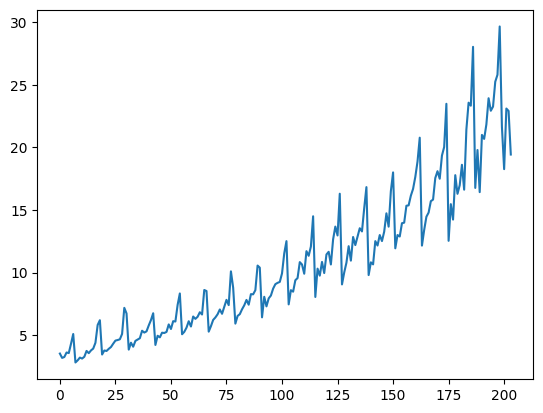

In [22]:
import matplotlib.pyplot as plt
plt.plot(y)

시계열에서 시간의 흐름에 따라 처방 건수가 증가하는 뚜렷한 추세를 볼 수 있고, 매년 낮은 값에서 시작하여 높은 값에서 끝나는 것처럼 보이는 강한 계절성도 관찰할 수 있다. 따라서 SARIMA모델을 활용할 것이다.

시계열 분해를 통해 추세와 계절성의 존재를 시각화해보자

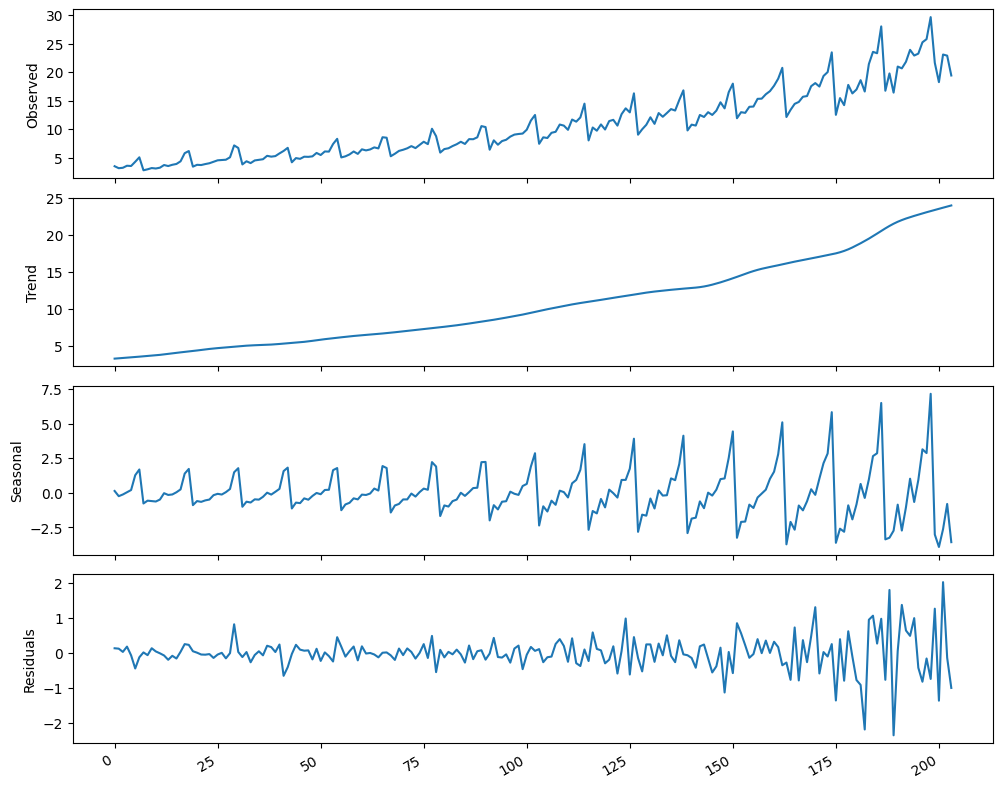

In [4]:
from statsmodels.tsa.seasonal import STL

decomposition = STL(y, period = 12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = (10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

# plt.xticks(np.arange(0,145,12), np.arange(1949, 1962,1))

fig.autofmt_xdate()
plt.tight_layout()

ADF 테스트를 통해 정상성을 테스트해보자

In [5]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(y)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  3.145185689306745
p-value :  1.0


p-value가 0.05보다 크므로 귀무가설을 기각할 수 없으며, 수열은 비정상적이다.  
1차 차분을 적용하고 정상성 테스트를 진행해보자

In [15]:
y_diff = np.diff(y, n = 1)
ADF_result = adfuller(y_diff)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -2.4951721474497903
p-value :  0.1166534168646754


수열은 여전히 비정상적이다.  
계절적 차분을 적용하고 정상성을 테스트해보자

In [16]:
y_seasonal_diff = np.diff(y_diff, n = 12)
y_seasonal_diff.shape

(191,)

In [17]:
ADF_result = adfuller(y_seasonal_diff)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -19.84844009618371
p-value :  0.0


수열이 정상적 상태가 된 것으로 간주할 수 있다.  

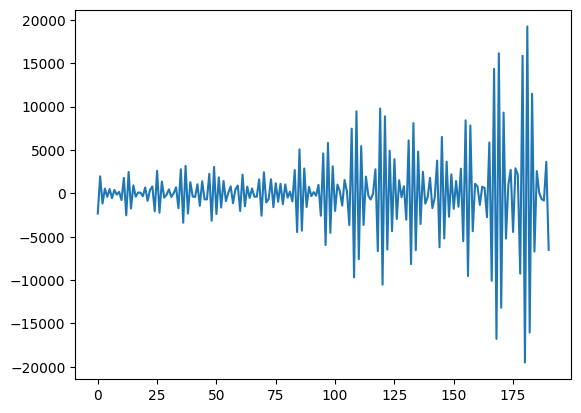

In [18]:
plt.plot(y_seasonal_diff)

# p,q,D,Q의 값 목록 만들기

이제 p,q, P,Q에 대해 가능한 값의 범위를 정의하고, 각각의 고유한 SARIMA(p,d,q)(P,D,Q)m모델을 피팅하여, AIC가 가장 낮은 모델을 선택해 보자.

In [19]:
from itertools import product
ps = range(0,4,1)
qs = range(0,4,1)
Ps = range(0,4,1)
Qs = range(0,4,1)

d = 1
D = 1
s = 12 # 매개변수 s는 m과 동일하다
order_list = list(product(ps,qs,Ps,Qs))

In [23]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_SARIMA(endog : Union[pd.Series, list],
                     order_list : list, d : int, D : int, s : int) -> pd.DataFrame:
  results = []

  for order in tqdm_notebook(order_list):
    p, q, P, Q = order[0], order[1], order[2], order[3]
    try :
      model = SARIMAX(
          endog,
          order = (p,d,q),
          seasonal_order = (P,D,Q,s),
          simple_differencing = False).fit(disp = False)
    except :
      continue
    aic = model.aic
    results.append([order,aic])

  results_df = pd.DataFrame(results)
  results_df.columns = ['(p,q,P,Q)', 'AIC']

  results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
  return results_df

In [24]:
SARIMA_result_df = optimize_SARIMA(train, order_list, d, D, s)
SARIMA_result_df

<ipython-input-23-18f12e5ec7c9>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,"(p,q,P,Q)",AIC
0,"(1, 0, 2, 3)",26.618683
1,"(3, 1, 1, 3)",270.951096
2,"(3, 3, 1, 3)",271.466318
3,"(3, 2, 1, 3)",272.222636
4,"(3, 3, 0, 1)",272.580413
...,...,...
251,"(0, 0, 3, 1)",351.425175
252,"(0, 0, 1, 1)",351.466837
253,"(0, 0, 0, 1)",354.751719
254,"(0, 0, 1, 0)",357.173706


SARIMA(1,1,0)(2,1,3)_12 모델이 AIC가 가장 낮다는 것을 알 수 있다.  
이 모델의 잔차 분석을 수행해 보자

# 잔차 분석

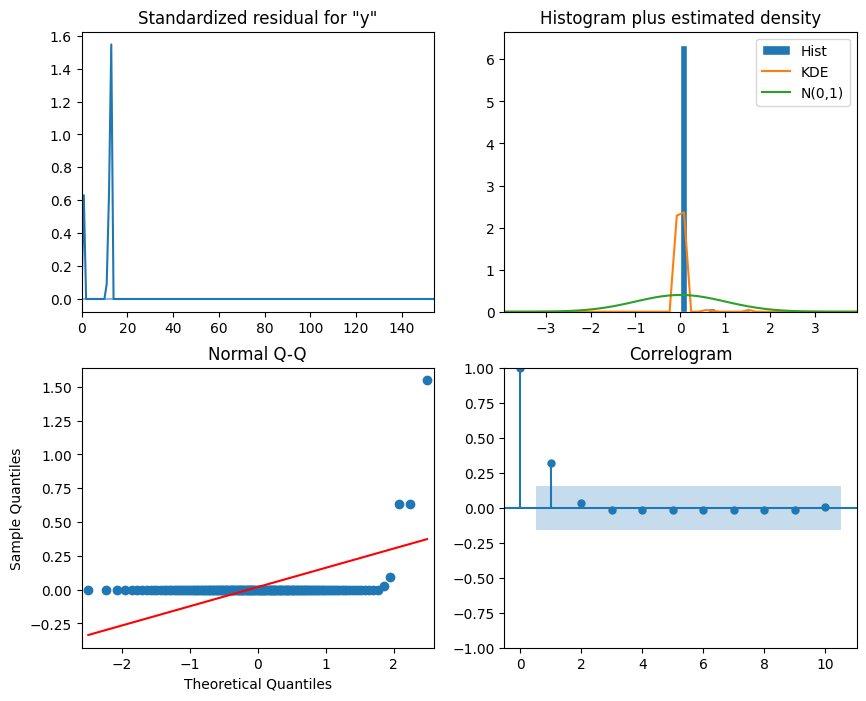

In [68]:
SARIMA_model = SARIMAX(train, order = (1,1,0), seasonal_order = (2,1,3,12), simple_differencing = False)
SARIMA_model_fit = SARIMA_model.fit(disp = False)
SARIMA_model_fit.plot_diagnostics(figsize = (10,8));

정성적 분석에서 Q-Q도식이 y=x에 가까운 직선을 표시하지 못하므로, 잔차가 백색소음이라고 볼 수 없다.  
다음 모델을 가지고 정성적 분석을 수행해보자

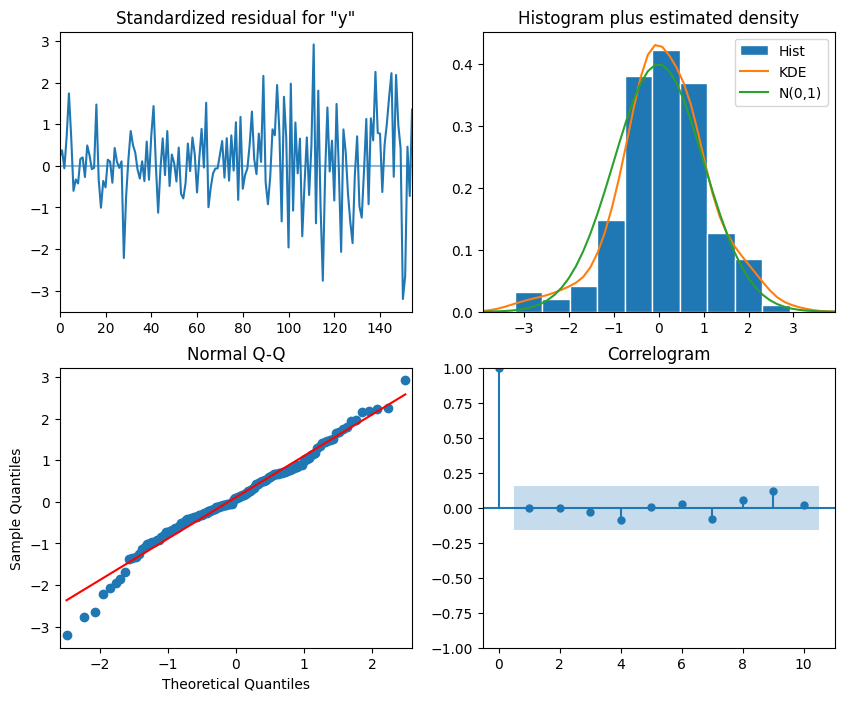

In [69]:
SARIMA_model = SARIMAX(train, order = (3,1,1), seasonal_order = (1,1,3,12), simple_differencing = False)
SARIMA_model_fit = SARIMA_model.fit(disp = False)
SARIMA_model_fit.plot_diagnostics(figsize = (10,8));

해당 모델은 잔차가 백색소음이라고 볼 수 있다.
다음으로 정량적 분석을 수행해보자

In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = SARIMA_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1,11,1)) # 처음 10개의 지연에 대해 융-박스 테스트를 수행
print(tr)

      lb_stat  lb_pvalue
1    0.436662   0.508738
2    0.627295   0.730777
3    0.645812   0.885869
4    2.257935   0.688438
5    2.949867   0.707715
6    3.388715   0.758712
7    9.981340   0.189633
8   10.591223   0.225954
9   11.853030   0.221722
10  11.984391   0.286102


p-value가 모두 0.05보다 크므로, 잔차간에 상관관계가 없다는 결론을 내릴 수 있다.

# 예측하기

잔차 분석의 모든 테스트를 통과했으므로, 2006년 한 해 동안의 항당뇨제 처방 건수를 예측하고, 예측값을 테스트 집합의 관측값과 비교해보자.  
우리의 모델이 베이스라인 모델보다는 더 좋은 결과를 내야 할 것이다.


한번에 12개월치의 데이터를 예측 가능하므로, 롤링 예측을 구현하여 예측해보자

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df : pd.DataFrame, train_len :int, horizon : int, window : int) -> list:
  total_len = train_len + horizon
  end_idx = train_len
  pred_SARIMA = []
  for i in range(train_len, total_len, window):
    model = SARIMAX(
        df[:i],
        order = (3,1,1),
        seasonal_order = (1,1,3,12),
        simple_differencing = False)
    res = model.fit(disp = False)
    predictions = res.get_prediction(0, i + window - 1)
    oos_pred = predictions.predicted_mean.iloc[-window:]
    pred_SARIMA.extend(oos_pred)
  return pred_SARIMA

In [106]:
TRAIN_LEN = len(train)
HORIZON = 36 # 예측해야 할 전체 데이터 개수 (3년치(36개월))
WINDOW = 12 # 한번에 예측할 데이터 개수 (1년치(12개월))

pred_sarima = rolling_forecast(y, TRAIN_LEN, HORIZON, WINDOW)
pred_sarima

[16.745954453433498,
 16.619417576712983,
 17.255356618140606,
 18.107602863345367,
 18.722355105066534,
 19.885764746378598,
 22.21663267534363,
 13.544399583004806,
 14.972348786992974,
 15.593446549829478,
 16.562099640936722,
 16.82858153549415,
 17.62802607038567,
 18.517436573976852,
 18.8344452473753,
 19.30838541880148,
 20.255215673483836,
 21.189825412608503,
 24.879443195958853,
 14.506432941645315,
 16.905441189849324,
 16.04945189574398,
 19.140851236350322,
 17.817257155536016,
 20.552296551663446,
 21.79875850346956,
 20.492593785079947,
 24.25939156608631,
 25.8618723932197,
 25.944540268351012,
 30.227481438017406,
 19.15573291101611,
 21.47026083831514,
 19.5547971204518,
 22.851283864730522,
 22.984278193894696]

In [107]:
test['SARIMA_pred'] = pred_sarima

# 예측 시각화 하기

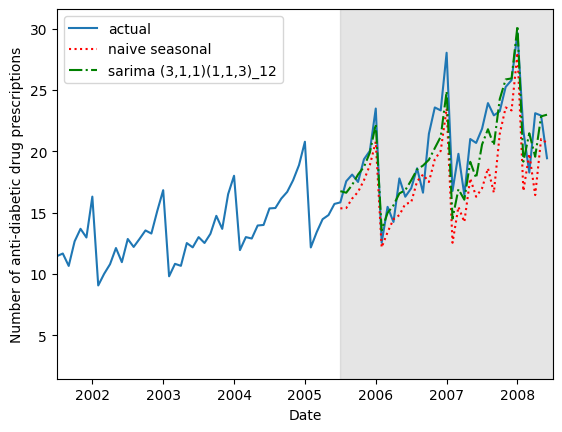

In [108]:
fig, ax = plt.subplots()
plt.plot(y, label = "actual")
plt.plot(test['naive_seasonal'], 'r:', label = 'naive seasonal')
plt.plot(test['SARIMA_pred'], 'g-.', label = 'sarima (3,1,1)(1,1,3)_12')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color = '#808080', alpha = 0.2)
plt.xticks(np.arange(6,203,12), np.arange(1992,2009,1))
ax.set_xlim(120, 204)
plt.legend()
plt.show()

# 성능 비교하기

성능을 정량적으로 평가하기 위해 MAPE, 평균 절대 백분율 오차를 사용해 보자.

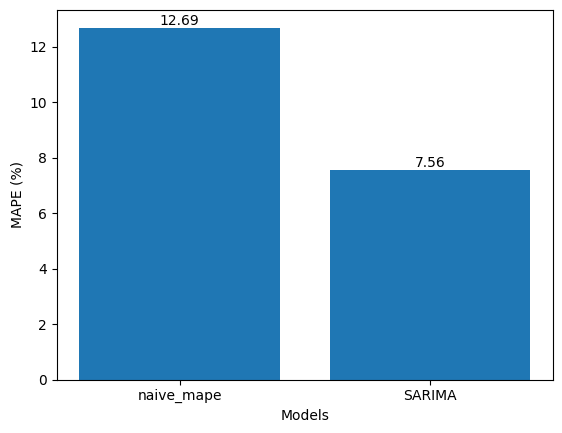

In [109]:
def mape(y_true, y_pred):
  return np.mean( np.abs( (y_true - y_pred)  / y_pred)) * 100

naive_mape = mape(test['naive_seasonal'], test['y'])
sarima_mape = mape(test['SARIMA_pred'], test['y'])

model_nm = ['naive_mape', 'SARIMA']
mapes = [naive_mape, sarima_mape]

fig,ax = plt.subplots()
plt.bar(model_nm, mapes)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

for index, height in enumerate(mapes):
  plt.text(x = index, y = height + 0.1, s = str(round(height,2)), ha = 'center')

plt.show()